# Project 4: Report C. Elegans
## Adriano Martinelli & Flurin Hidber

### Introduction

**NOTE**: The cells that contain the delivarables are indicated by a heading "Deliverable XX"

In this notebook we analyse the C. elegans data set with the following standard models:
    * SVC
    * Random Forest
    * Categorical Naive Bayes
    * XGBoost
    * Logistic Regression
    
For each model we perfrom hyper-parameter tuning with cross-validation to find the optimal parameters.

### Set-Up Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from functools import partial

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid 
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,precision_recall_curve, auc, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

### Variables & Helper-Functions

We apply a very naive and basic feature engineering.

* Count of each nucleotide
* Count of each dinucleotide
* Sequence itself for naive bayes model

Feature engineering is the part we could most improve upon. Possible approaches would be to convolut the sequences (implemented in the neural net notebook) or to generate features for the parts before and after the central AG individually. We did not experiment more with the feature engineering since we were able to find a good model without more complex features.

In [2]:
# Global variables
nuc = ['A', 'T', 'G', 'C']
dinuc = itertools.product(nuc, repeat = 2)
dinuc =[i[0]+i[1] for i in dinuc]

random_state = 42

# Metrics
metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name =[i.__name__ for i in metrics]
metrics = [accuracy_score, partial(precision_score,zero_division=0), recall_score, f1_score]

# #Helper Functions
def central_ag(x):
    ''' Finde the most central AG dinucleotide'''
    acc = [i.start() for i in re.finditer('AG', x)]
    dis = [abs(i-len(x)/2) for i in acc]
    return acc[np.argmin(dis)]
    
def prep_data(X,y):
    '''Engineer features for models'''
    
    # # Features engineering
    nuc_counts = X.apply(lambda x: [x.count(i) for i in nuc])
    dinuc_counts = X.apply(lambda x: [x.count(i) for i in dinuc])
    df = nuc_counts + dinuc_counts
    df = pd.DataFrame([*df], columns = nuc+dinuc)
    
    return df.values, y.values

def prep_nb(X,y):
    '''Engineer features for Naive-Bayes model'''
    tmp = X.apply(lambda x: [i for i in x])
    tmp = pd.DataFrame([*tmp])
    
    le = LabelEncoder()
    le.fit(nuc)
    
    tmp = tmp.apply(lambda x: le.transform(x))
    
    return tmp.values, y.values

### Load Data
Here we load the data and split it into a training and a test set.

In [4]:
# #Read in data
df = pd.read_csv('exercise_data/C_elegans_acc_seq.csv', header=None, names =['label', 'seq'])
y = df.label
X = df.seq

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = random_state)

### Parameter Grid

In [6]:
parameters ={'rf': {'n_estimators': [50,100,300],
                    'n_jobs': [-1],
                    'class_weight': ['balanced', None],
                    'random_state': [random_state]},
             
             'xgboost': {'learning_rate': np.logspace(-2,0,3),
                         'n_jobs': [8],
                         'scale_pos_weight': [1, y_train.value_counts()[-1]/y_train.value_counts()[1]]
                 },
             
             'svc': {'C': np.logspace(-2,2,4),
                     'kernel': ['linear', 'poly', 'rbf'],
                     'class_weight': ['balanced', None],
                     'random_state': [random_state]
                 },
             'nb': {'alpha': np.logspace(-2,1,4),
                    'fit_prior': [True, False],
                    'class_prior': [[.5, .5], None]
                    },
             'logreg': {
                 'penalty': ['l2', 'l1', 'elasticnet'],
                 'l1_ratio':[0.5],
                 'class_weight': [None, 'balanced'],
                 'solver': ['saga'],
                 'random_state': [random_state],
                 'n_jobs':[-1],
                 'max_iter': [1000]
                 }
    }

# Model Selection
In the following we are defining a `model_evaluation` function which will help us to evaluate different models
and compare them at a later stage.


### Deliverable 1
- Do your own experimental setup (cross validation, random split, etc.).

The function `model_evaluation` performs the whole grid-search and cross-validation. In a first step the data is split into 5 stratified folds for training and validation of the hyper-parameters. The model is fit and the performance of the predictions in terms of accuracy, precision, recall and f1 score are stored. 

In [9]:
def model_evaluation(model, x, y, param_grid, model_name, cv=5):
    
    # # Results, initialise
    res = pd.DataFrame(index= ['setting', 'params', 'split']+metrics_name)

    # # Cross Validation
    # kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    setting = 1
    for params in param_grid:
        split = 1
        for idx_train, idx_val in kf.split(x, y):
            
            #Sample dist
            n_pos_train = np.sum(y[idx_train] == 1)
            n_neg_train = np.sum(y[idx_train] == -1)
            n_pos_val = np.sum(y[idx_val] == 1)
            n_neg_val = np.sum(y[idx_val] == -1)
            
            #Set parameters
            model.set_params(**params)
            
            #Fit model
            model.fit(x[idx_train], y[idx_train])
            
            #Predict on validation set
            pred = model.predict(x[idx_val])
            
            #Compute scores
            score = [m(y[idx_val], pred) for m in metrics]
            
            #Append to result df
            s = [setting, params, split] + score + [n_pos_train, n_neg_train, n_pos_val, n_neg_val]
            s = pd.Series(s, index = ['setting', 'params', 'split']+metrics_name + ['n_pos_train', 'n_neg_train', 'n_pos_val', 'n_neg_val'], name=model_name)
            res = pd.concat([res, s], axis=1)
            split += 1
        
        setting += 1
        
    return res

In [10]:
# # Models
rf = RandomForestClassifier()
xgboost = XGBClassifier()
svc = SVC()
nb = CategoricalNB()
logreg = LogisticRegression()

# # Preprocess data
x_prep, y_prep = prep_data(x_train, y_train)

#Initialise structure to store results
results = dict()

# ## Random Forest
print('rf')
results['rf'] = model_evaluation(rf, x_prep, y_prep, list(ParameterGrid(parameters['rf'])), 'rf', cv=5)

# ## xgboost
print('xgboost')
results['xgboost'] = model_evaluation(xgboost, x_prep, y_prep, list(ParameterGrid(parameters['xgboost'])), 'xgboost', cv=5)

# ## SVC
print('svc')
results['svc'] = model_evaluation(svc, x_prep, y_prep, list(ParameterGrid(parameters['svc'])), 'svc', cv=5)

# ## Logistic Regression
print('logreg')
results['logreg'] = model_evaluation(logreg,x_prep, y_prep, list(ParameterGrid(parameters['logreg'])), 'logreg', cv=5)

# ## Naive Bayes
print('nb')
#prep data for CategoricalNB()
x_prep, y_prep = prep_nb(x_train, y_train)
results['nb'] = model_evaluation(nb, x_prep, y_prep, list(ParameterGrid(parameters['nb'])), 'nb', cv=5)

rf


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

xgboost


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

svc


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

logreg


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

nb


/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/adrianomartinelli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavi

### Aggregation of Results

In [11]:
# ## Aggregate results
tbl = pd.concat(results, axis=1)

# Adjust columns
idx = list(tbl.columns)
idx = [i[0] for i in idx]
tbl.columns = range(tbl.shape[1])

# Add model as index
s = pd.DataFrame(idx, columns =['model'])
tbl = pd.concat([tbl, s.T], axis = 0)

tmp = tbl.T

# Cast dtype of metrics to float
cols = ['setting', 'accuracy_score', 'precision_score', 'recall_score','f1_score']
for i in cols:
    tmp[i]=tmp[i].astype('float32')

cols = ['model'] + cols
summary = tmp[cols].groupby(['model', 'setting']).agg([min,max, "mean", np.std])

#Sort models according to f1 mean score
model_selection = summary.sort_values(('f1_score','mean'), ascending=False)

### Deliverable 2
- Pandas dataframe showing a comparison of the scores of the models you tried. Three columns: model name,
AUROC, AUPRC, scores for the test set

The tested model do not all allow to compute ROC and PR curves. We therefore decided to summarise the model performance based on the metrices: accuracy, precision, recall and f1_score. In the `summary` table we report min, max, mean and std values for each setting of a model (based on 5-fold cross-validation).

The table `model_selection` shows the models sorted according to mean f1_score

In [13]:
summary

accuracy_score                               precision_score  \
                           min       max      mean       std             min   
model   setting                                                                
logreg  1.0           0.902597  0.915584  0.905844  0.005624        0.000000   
        2.0           0.902597  0.912338  0.905844  0.003976        0.000000   
        3.0           0.902597  0.912338  0.905195  0.004233        0.000000   
        4.0           0.646104  0.678571  0.661039  0.013698        0.138889   
        5.0           0.642857  0.681818  0.661039  0.014628        0.138889   
        6.0           0.642857  0.678571  0.660390  0.013504        0.138889   
nb      1.0           0.941558  0.970779  0.959740  0.012278        0.641026   
        2.0           0.941558  0.970779  0.959740  0.012278        0.641026   
        3.0           0.954545  0.977273  0.968831  0.008772        0.727273   
        4.0           0.941558  0.970779  0.959740  0.012278        0.641026   
        5.0           0.944805  0.967532  0.957792  0.010768        0.644444   
        6.0           0.944805  0.967532  0.957792  0.010768        0.644444   
        7.0           0.954545  0.977273  0.968831  0.008772        0.727273   
        8.0           0.944805  0.967532  0.957792  0.010768        0.644444   
        9.0           0.931818  0.964286  0.950649  0.014592        0.580000   
        10.0          0.931818  0.964286  0.950649  0.014592        0.580000   
        11.0          0.951299  0.980519  0.968182  0.011106        0.705882   
        12.0          0.931818  0.964286  0.950649  0.014592        0.580000   
        13.0          0.873377  0.915584  0.897403  0.015332        0.426471   
        14.0          0.873377  0.915584  0.897403  0.015332        0.426471   
        15.0          0.948052  0.974026  0.962987  0.010164        0.685714   
        16.0          0.873377  0.915584  0.897403  0.015332        0.426471   
rf      1.0           0.896104  0.905844  0.903247  0.004233        0.000000   
        2.0           0.899351  0.905844  0.903896  0.002904        0.000000   
        3.0           0.902597  0.905844  0.903896  0.001778        0.000000   
        4.0           0.902597  0.909091  0.904545  0.002904        0.000000   
        5.0           0.899351  0.909091  0.904545  0.003702        0.000000   
        6.0           0.902597  0.909091  0.905195  0.002716        0.000000   
svc     1.0           0.600649  0.646104  0.620130  0.017180        0.132812   
        2.0           0.525974  0.581169  0.558442  0.021659        0.127389   
        3.0           0.198052  0.750000  0.351299  0.225344        0.105072   
        4.0           0.902597  0.905844  0.905195  0.001452        0.000000   
        5.0           0.902597  0.905844  0.905195  0.001452        0.000000   
        6.0           0.902597  0.905844  0.905195  0.001452        0.000000   
        7.0           0.626623  0.678571  0.641558  0.021241        0.140351   
        8.0           0.597403  0.636364  0.611039  0.016777        0.148148   
        9.0           0.558442  0.607143  0.586364  0.020354        0.140845   
        10.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        11.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        12.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        13.0          0.616883  0.675325  0.640260  0.021828        0.141593   
        14.0          0.659091  0.724026  0.694805  0.028858        0.178571   
        15.0          0.620130  0.707792  0.660390  0.033158        0.156250   
        16.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        17.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        18.0          0.902597  0.905844  0.905195  0.001452        0.000000   
        19.0          0.616883  0.675325  0.640260  0.021828        0.141593   
        20.0    

### Deliverable 3
- Find best model possible (try different models, do hyperparameter search, etc).

We selected the model based on the mean f1_score. We observe that the naive bayes approach performs very good on this data set compared to the other models. We assume this may be because our feature engineering is not very sophisticated and the other models performance is strongly influenced by the availablity of good features, whereas the naive bayes approach does not require any special feature engineering.

The best performing model is the naive bayes model with the floowing parameters: {'alpha': 0.01, 'class_prior': None, 'fit_prior': True}

In [16]:
# Select best peforming model and parameters
top_model = model_selection.head(1)
top_model = top_model.index.tolist()[0]
tmp = tbl.loc[:,(tbl.loc['model']== top_model[0]).values & (tbl.loc['setting']== top_model[1]).values]
best_params = tmp.loc['params'].iloc[0]

### Deliverable 4
We now train the best model with the whole trainings data set and assess performance in terms of accuracy, precision, recall and f1_score for training and test data set.

We can see that training scores and test scores are equivalent, i.e. we are confident to not have overfitted the model. Furthermore the ROC and PR curves are very good with a AUROC of 0.9942. In addition to the curves we show the confusion matrix normalised with respect to the true label.

In [19]:
# ## Test model
nb = CategoricalNB()
nb.set_params(**best_params)

#Prep data
x, y = prep_nb(x_train, y_train)

#Fit model
nb.fit(x, y)

#Compute performance on training set
pred = nb.predict(x)
score_training = [m(y, pred) for m in metrics]

#Predict on test set
x, y = prep_nb(x_test, y_test)
pred = nb.predict(x)

#Compute scores
score = [m(y, pred) for m in metrics]

print(score_training)
print(score)

[0.974025974025974, 0.83125, 0.910958904109589, 0.8692810457516339]
[0.9803030303030303, 0.8596491228070176, 0.9074074074074074, 0.8828828828828829]


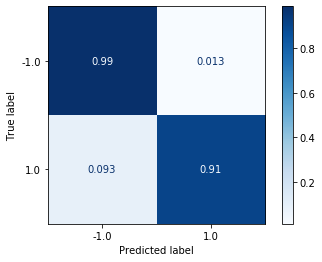

Text(0.5, 1.0, 'Precision-Recall Curve')

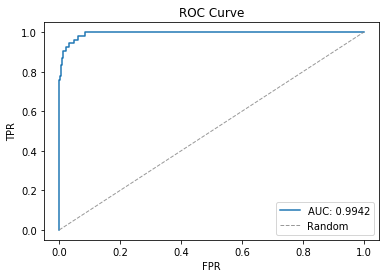

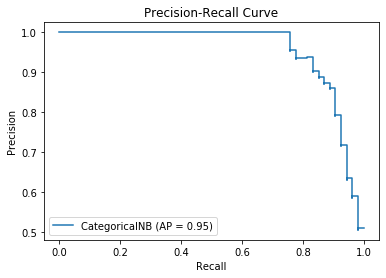

In [21]:
plot_confusion_matrix(nb, x,y, cmap=plt.cm.Blues, normalize='true')
plt.show()

y_prop = nb.predict_proba(x)
y_prop =y_prop[:,1]
roc =roc_curve(y_test, y_prop)

label = 'AUC: {:.4}'.format(auc(roc[0], roc[1]))
plt.plot(roc[0], roc[1], label = label)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',label='Random', alpha=.8)
plt.legend()
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

#PR curve
prc = plot_precision_recall_curve(nb, x, y)
prc.ax_.set_title('Precision-Recall Curve')
